In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

### Asset price movement graph:

In [2]:
def quotes_downloader(ticker, start, end):
    url = "".join(("https://stooq.pl/q/d/l/?s=", ticker, "&d1=", start, "&d2=", end, "&i=d"))
    df = pd.read_csv(url)
    df = df[['Data','Zamkniecie']]
    df['Data'] = pd.to_datetime(df["Data"], format='%Y-%m-%d')
    df.set_index('Data', inplace=True)
    df.rename(columns={'Zamkniecie':ticker}, inplace=True)
    return df

In [3]:
Start = "20000101"
End = "20180413"
ticker = 'MWIG40'
mWIG = quotes_downloader(ticker, Start, End)

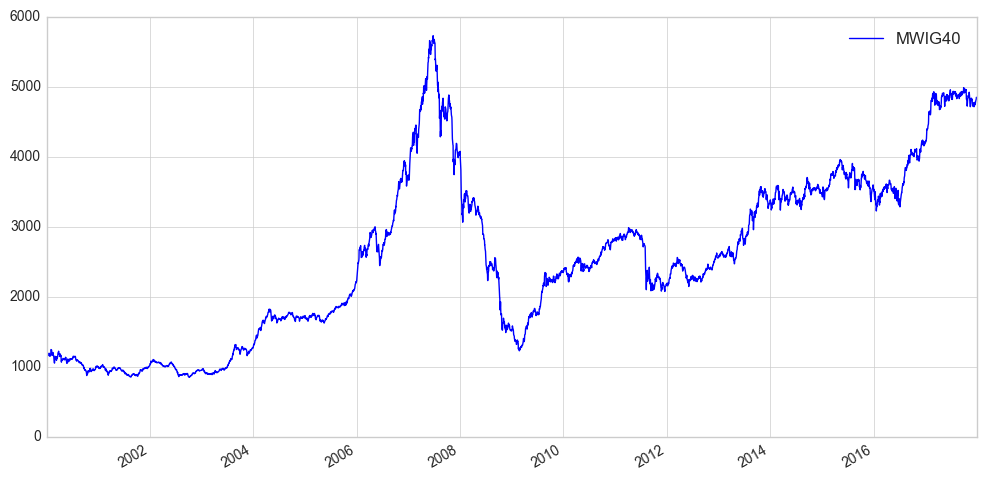

In [16]:
mWIG.plot(figsize=(12, 6))
plt.xlabel('');

### Create DataFrame with 10-month moving average based on daily returns

In [5]:
def create_daily_ma(df, ticker):
    df2 = df.copy()
    df2['Moving_Average'] = df2[ticker].rolling(window=208, min_periods=1).mean()
    df2['MA-Current_price'] = df2['Moving_Average'] - df2[ticker]
    return df2

In [6]:
mWIG_daily = create_daily_ma(mWIG, ticker)
mWIG_daily.head()

,MWIG40,Moving_Average,MA-Current_price
Data,,,
2000-01-03,1140.10,1140.10,0.00
2000-01-04,1103.80,1121.95,18.15
2000-01-05,1086.10,1110.00,23.90
2000-01-06,1105.30,1108.82,3.52
2000-01-07,1147.80,1116.62,-31.18


In [24]:
amount_to_invest = 10000
monthly_interest = 0.02 / 12
def complete_df_creator(df, ticker, Y, M, D):
    df3 = df.asfreq(freq='M', method='ffill').loc[dt.datetime(Y,M,D):]
    investment_start_price = df3[ticker][0]
    shares_bought = amount_to_invest / investment_start_price
    df3['B&H_Shares'] = shares_bought
    df3['B&H_Value'] = shares_bought * df3[ticker]
    df3['action'] = 'Buy'
    df3.loc[df3['MA-Current_price'] > 0, 'action'] = 'Sell'
    df3.loc[(df3['action'] == 'Buy') & (df3['action'].shift(1) == 'Buy'),'action'] = 'Hold Asset'
    df3.loc[(df3['action'] == 'Sell') & (df3['action'].shift(1) == 'Sell'),'action'] = 'Hold Cash'
    # Set up Trend Following columns as a placeholders:
    df3['TF_Shares'] = 0
    df3['TF_Value'] = 0
    df3['TF_Cash'] = 0

    n = 0
    for i, row in df3.iterrows():
        prev_val = df3['TF_Value'].iloc[n-1]
        prev_cash = df3['TF_Cash'].iloc[n-1]
        prev_shares = df3['TF_Shares'].iloc[n-1]
        cur_val = row['TF_Value']
        cur_price = df3.loc[i,ticker]
        if row['action'] == 'Sell' and prev_shares == 0:
            df3.loc[i,'TF_Shares'] = 0
            df3.loc[i,'TF_Cash'] = amount_to_invest
            df3.loc[i,'TF_Value'] = 0
        elif row['action'] == 'Sell':
            df3.loc[i,'TF_Shares'] = 0
            df3.loc[i,'TF_Cash'] = prev_shares * cur_price
            df3.loc[i,'TF_Value'] = 0
        elif row['action'] == 'Hold Cash' and prev_cash == 0:
            df3.loc[i,'TF_Shares'] = 0
            df3.loc[i,'TF_Cash'] = amount_to_invest
            df3.loc[i,'TF_Value'] = 0
        elif row['action'] == 'Hold Cash':
            df3.loc[i,'TF_Shares'] = 0
            df3.loc[i,'TF_Cash'] = prev_cash * (1 + monthly_interest)
            df3.loc[i,'TF_Value'] = 0
        elif row['action'] == 'Buy' and prev_cash == 0:
            df3.loc[i,'TF_Shares'] = amount_to_invest / investment_start_price
            df3.loc[i,'TF_Cash'] = 0
            df3.loc[i,'TF_Value'] = shares_bought * cur_price
        elif row['action'] == 'Buy':
            cur_shares = (prev_cash * (1 + monthly_interest)) / cur_price
            df3.loc[i,'TF_Shares'] = cur_shares
            df3.loc[i,'TF_Cash'] = 0
            df3.loc[i,'TF_Value'] = cur_shares * cur_price
        elif row['action'] == 'Hold Asset' and prev_shares == 0:
            df3.loc[i,'TF_Shares'] = amount_to_invest / investment_start_price
            df3.loc[i,'TF_Cash'] = 0
            df3.loc[i,'TF_Value'] = shares_bought * cur_price
        elif row['action'] == 'Hold Asset':
            df3.loc[i,'TF_Shares'] = prev_shares
            df3.loc[i,'TF_Cash'] = 0
            df3.loc[i,'TF_Value'] = prev_shares * cur_price
        df3['TF_Total_Val'] = df3['TF_Cash'] + df3['TF_Value']
        n += 1
    return df3

In [8]:
final_Mwig = complete_df_creator(mWIG_daily, ticker, 2001, 1, 1)
final_Mwig.head(n=20)

,MWIG40,Moving_Average,MA-Current_price,B&H_Shares,B&H_Value,action,TF_Shares,TF_Value,TF_Cash,TF_Total_Val
Data,,,,,,,,,,
2001-01-31,1017.97,1040.74,22.77,9.82,10000.00,Sell,0.00,0.00,10000.00,10000.00
2001-02-28,950.02,1026.34,76.32,9.82,9332.50,Hold Cash,0.00,0.00,10016.67,10016.67
2001-03-31,944.89,1007.88,62.99,9.82,9282.10,Hold Cash,0.00,0.00,10033.36,10033.36
2001-04-30,985.86,995.71,9.85,9.82,9684.57,Hold Cash,0.00,0.00,10050.08,10050.08
2001-05-31,986.68,979.36,-7.32,9.82,9692.62,Buy,10.20,10066.83,0.00,10066.83
2001-06-30,944.90,967.92,23.02,9.82,9282.20,Sell,0.00,0.00,9640.56,9640.56
2001-07-31,884.80,956.17,71.37,9.82,8691.81,Hold Cash,0.00,0.00,9656.63,9656.63
2001-08-31,891.95,950.33,58.38,9.82,8762.05,Hold Cash,0.00,0.00,9672.73,9672.73
2001-09-30,889.84,943.91,54.07,9.82,8741.32,Hold Cash,0.00,0.00,9688.85,9688.85


### Asset price plot with action points and summary statistics informaton

In [110]:
def plot_with_actions(df, ticker):
    df3 = df.copy()
    month_ends = df3.shape[0]
    sell_df = df3[df3['action'] == 'Sell']
    sell_prices = list(sell_df[ticker])
    sell_dates = list(sell_df.index)

    buy_df = df3[df3['action'] == 'Buy']
    buy_prices = list(buy_df[ticker])
    buy_dates = list(buy_df.index)
    
    # To confirm if first recommended action was buy or sell
    gains = []
    losses = []
    # When sell recommendation was firts
    if sell_dates[0] < buy_dates[0]:
        for sell, buy in zip(sell_prices, buy_prices):
            if (sell - buy) > 0:
                gains.append(['S', sell, 'B', buy])
            else:
                losses.append(['S', sell, 'B', buy])

    # When sell recommendation was firts
    if sell_dates[0] > buy_dates[0]:
        for sell, buy in zip(sell_prices, buy_prices[1:]):
            if (sell - buy) > 0:
                gains.append(['S', sell, 'B', buy])
            else:
                losses.append(['S', sell, 'B', buy])

    avg_sell_gain = np.mean([x[1] for x in gains])
    avg_buy_gain = np.mean([x[3] for x in gains])
    avg_when_right = (avg_sell_gain / avg_buy_gain - 1) * 100

    avg_sell_loss = np.mean([x[1] for x in losses])
    avg_buy_loss = np.mean([x[3] for x in losses])
    avg_when_wrong = (avg_sell_loss / avg_buy_loss - 1) * 100
    
    buy_hold_final = df['B&H_Value'][-1]
    trend_following_final = df['TF_Total_Val'][-1]

    print('Analyze period included {} month ends with {} sell and repurchase actions:' 
          .format(month_ends, min(df3[df3['action']=='Sell'].shape[0], df3[df3['action']=='Buy'].shape[0])))
    print('*   of which {} or {}% were correct as it allowed to repurchase {}% more asset'
         .format(len(gains), round(len(gains)/(len(gains) + len(losses))*100), round(avg_when_right,1)))
    print('*   of which {} or {}% were wrong as it allowed to repurchase {}% less asset '
         .format(len(losses), round(len(losses)/(len(gains) + len(losses))*100), round(avg_when_wrong,1)))
    if buy_hold_final > trend_following_final:
        print('\nBuy and Hold outperformed Trend Follwing by {:0.1f}% or {:0.0f}' 
              .format((buy_hold_final/trend_following_final-1)*100, buy_hold_final - trend_following_final))
    elif buy_hold_final < trend_following_final:
        print('\nTrend Following outperformed Buy and Hold by {:0.1f}% or {:0.0f}' 
              .format((trend_following_final/buy_hold_final-1)*100, trend_following_final - buy_hold_final))
    print('*   Final Value of Buy and Hold strategy is {}' .format(int(buy_hold_final)))
    print('*   Final Value of Trend Following strategy is {}' .format(int(trend_following_final)))

    plt.figure(figsize=(12,6))
    plt.legend(ticker)
    ax = plt.plot(df3.index, df3[ticker], linewidth=2, color='k')
    # red dots to indicate a sell action on a plot
    for date, price in zip(sell_dates, sell_prices):
        plt.plot(date, price, color='r', marker='.', markersize=16)

    # green dots to indicate a repurchase action on a plot    
    for date, price in zip(buy_dates, buy_prices):
        plt.plot(date, price, color='g', marker='.', markersize=16)

Analyze period included 203 month ends with 12 sell and repurchase actions:
*   of which 5 or 42% were correct as it allowed to repurchase 33.3% more asset
*   of which 7 or 58% were wrong as it allowed to repurchase -4.9% less asset 

Trend Following outperformed Buy and Hold by 160.9% or 75078
*   Final Value of Buy and Hold strategy is 46663
*   Final Value of Trend Following strategy is 121742


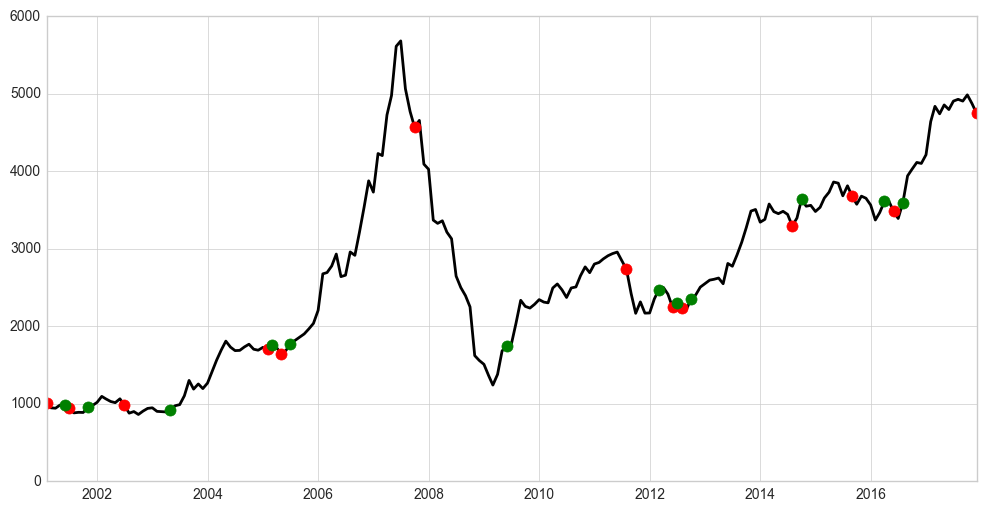

In [111]:
plot_with_actions(final_Mwig, ticker)

### Buy & Hold vs Trend Following comparison 

In [104]:
def compirson_creator(df, ticker):
    df3 = df.copy()
    df3['TF-B&H'] = df3['TF_Total_Val'] - df3['B&H_Value']
    df3['TF-B&H_ret(%)'] = (df3['TF-B&H'] / df3['B&H_Value'])*100

    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,8))
    ax1.plot(df3.index, df3['B&H_Value'], linewidth = 2, color='dimgrey', alpha=0.6)
    ax1.plot(df3.index, df3['TF_Total_Val'], linewidth = 2, color='b', alpha=0.6)
    ax1.legend(loc='best')
    ax1.set_ylabel('Investment Value (PLN)')
    ax1.set_title('Buy & Hold and Trend Following 10,000 investment value', fontsize=15)
    ax2.fill_between(df3.index, y1=df3['TF-B&H'], y2=0, color='r', where=df3['TF-B&H']<0)
    ax2.fill_between(df3.index, y1=df3['TF-B&H'], y2=0, color='g', where=df3['TF-B&H']>0)
    ax2.set_ylabel('Difference (PLN)')
    ax2.set_title('Difference (Buy & Hold - Trend Following)')
    ax2.legend(["Trend Following underperformance", "Trend Following outperformance"], loc='upper left');
    #return df3.tail()

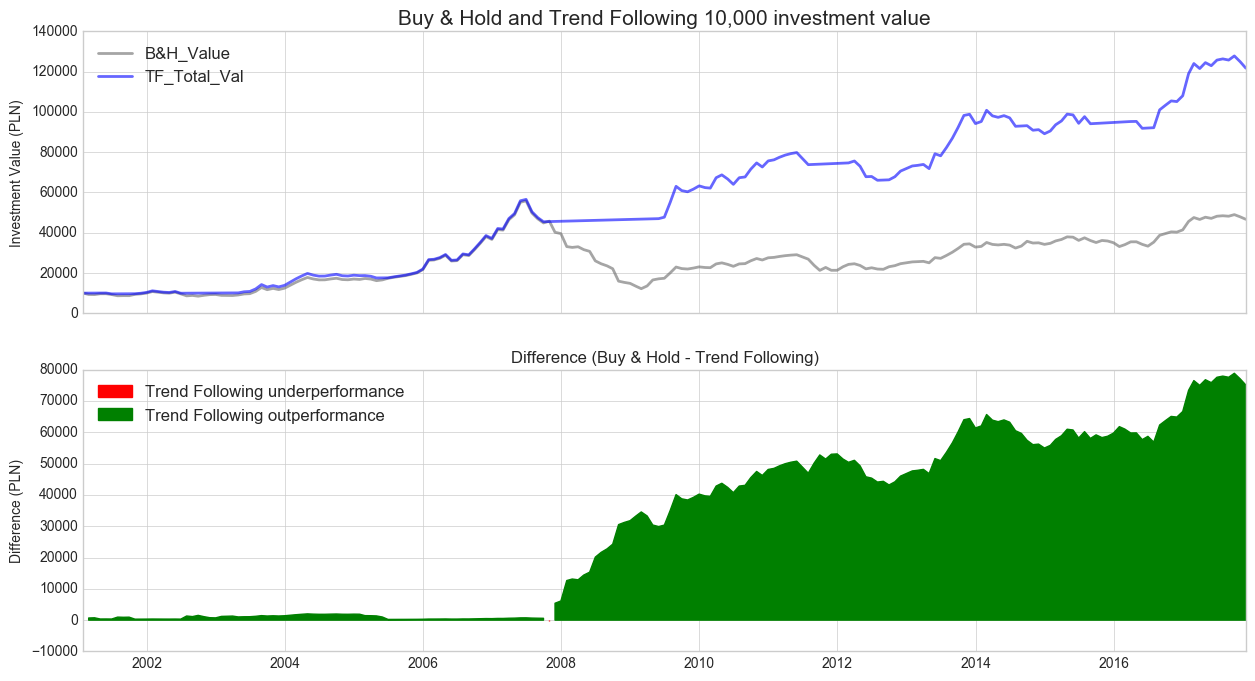

In [105]:
compirson_creator(final_Mwig, ticker)

# Study 2: Currency 

In [13]:
Start = "20000101"
End = "20180413"
ticker2 = 'sgdpln'
sgd = quotes_downloader(ticker2, Start, End)

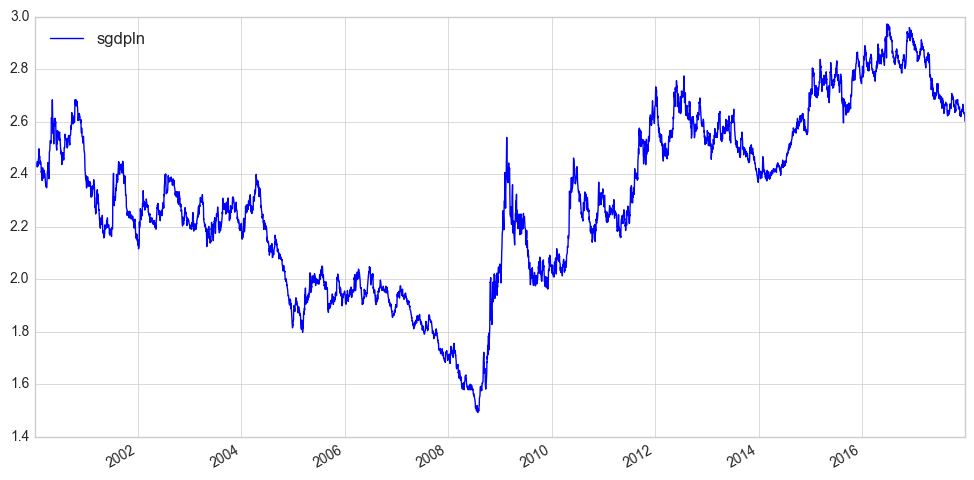

In [18]:
sgd.plot(figsize=(12, 6))
plt.xlabel('');

In [22]:
sgd_daily = create_daily_ma(sgd, ticker2)
sgd_daily.head()

,sgdpln,Moving_Average,MA-Current_price
Data,,,
2000-01-03,2.48,2.48,0.00
2000-01-04,2.49,2.48,-0.01
2000-01-05,2.49,2.49,-0.01
2000-01-06,2.45,2.48,0.03
2000-01-07,2.45,2.47,0.02


In [25]:
final_sgd = complete_df_creator(sgd_daily, ticker2, 2001, 1, 1)
final_sgd.head(n=20)

,sgdpln,Moving_Average,MA-Current_price,B&H_Shares,B&H_Value,action,TF_Shares,TF_Value,TF_Cash,TF_Total_Val
Data,,,,,,,,,,
2001-01-31,2.34,2.53,0.19,4272.96,10000.00,Sell,0.00,0.00,10000.00,10000.00
2001-02-28,2.31,2.52,0.20,4272.96,9891.04,Hold Cash,0.00,0.00,10016.67,10016.67
2001-03-31,2.27,2.49,0.22,4272.96,9682.95,Hold Cash,0.00,0.00,10033.36,10033.36
2001-04-30,2.17,2.45,0.28,4272.96,9292.40,Hold Cash,0.00,0.00,10050.08,10050.08
2001-05-31,2.20,2.42,0.22,4272.96,9400.93,Hold Cash,0.00,0.00,10066.83,10066.83
2001-06-30,2.20,2.39,0.19,4272.96,9389.82,Hold Cash,0.00,0.00,10083.61,10083.61
2001-07-31,2.36,2.36,-0.00,4272.96,10081.61,Buy,4280.93,10100.42,0.00,10100.42
2001-08-31,2.43,2.33,-0.11,4272.96,10404.22,Hold Asset,4280.93,10423.63,0.00,10423.63
2001-09-30,2.39,2.31,-0.08,4272.96,10230.74,Hold Asset,4280.93,10249.82,0.00,10249.82


Analyze period included 203 month ends with 24 sell and repurchase actions:
*   of which 3 or 12% were correct as it allowed to repurchase 8.0% more asset
*   of which 21 or 88% were wrong as it allowed to repurchase -2.6% less asset 

Buy and Hold outperformed Trend Follwing by 4.7% or 502
*   Final Value of Buy and Hold strategy is 11194
*   Final Value of Trend Following strategy is 10691


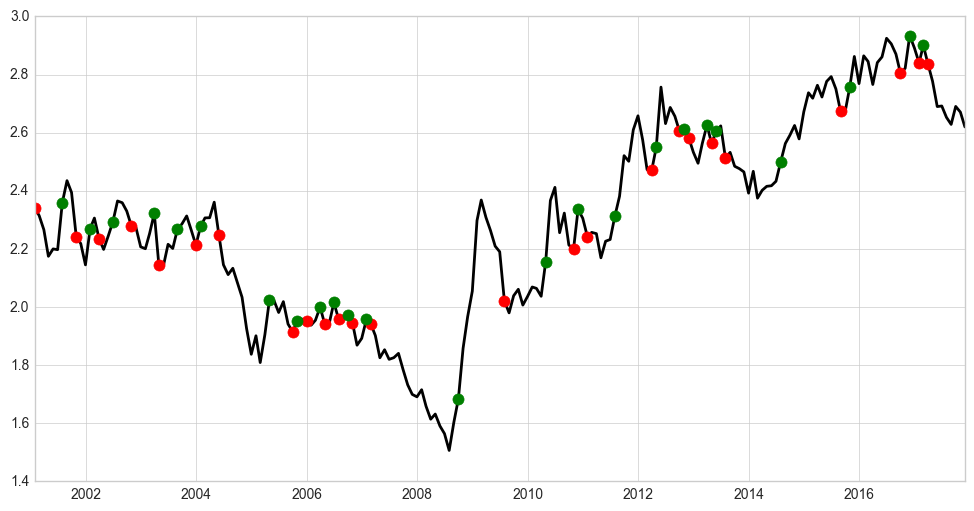

In [112]:
plot_with_actions(final_sgd, ticker2)

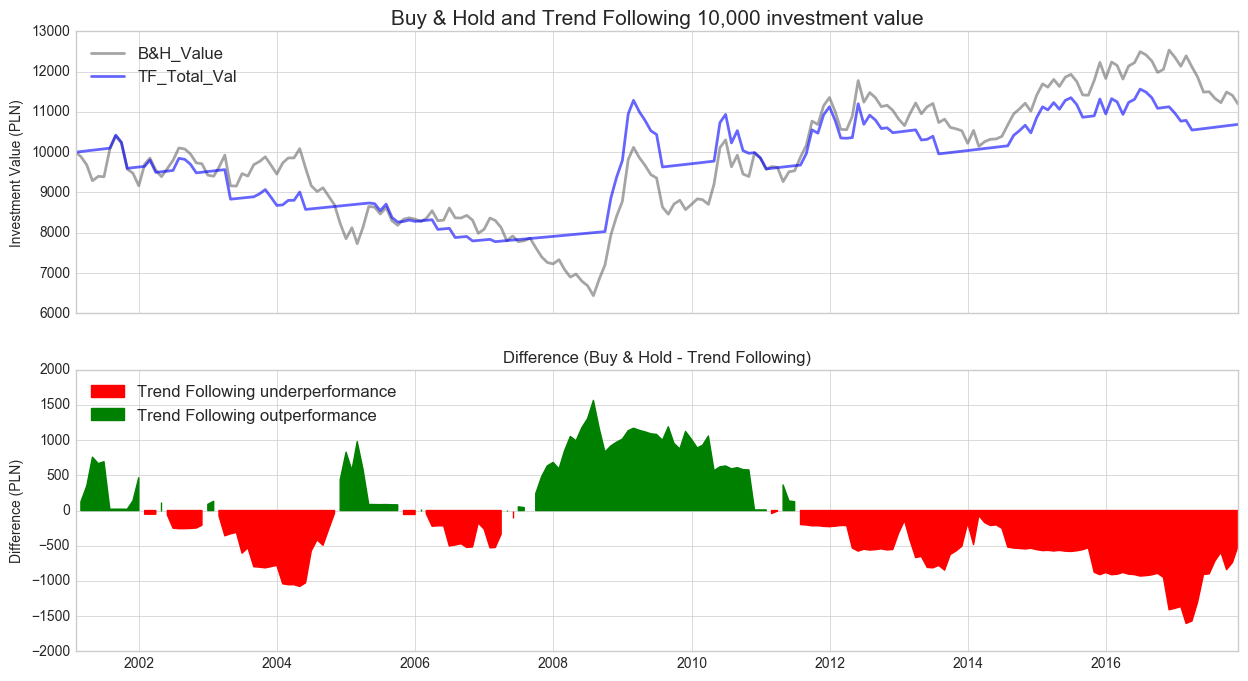

In [113]:
compirson_creator(final_sgd, ticker2)